## ThinkDSP

This notebook contains code examples from Chapter 1: Sounds and Signals

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)


## Think DSP module

`thinkdsp` is a module that accompanies _Think DSP_ and provides classes and functions for working with signals.

[Documentation of the thinkdsp module is here](http://greenteapress.com/thinkdsp.html). 

In [ ]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

## Signals

Instantiate cosine and sine signals.

In [1]:
from thinkdsp import CosSignal, SinSignal

cos_sig = CosSignal(freq=440, amp=1.0, offset=0)
sin_sig = SinSignal(freq=880, amp=0.5, offset=0)

Plot the sine and cosine signals.  By default, `plot` plots three periods.  

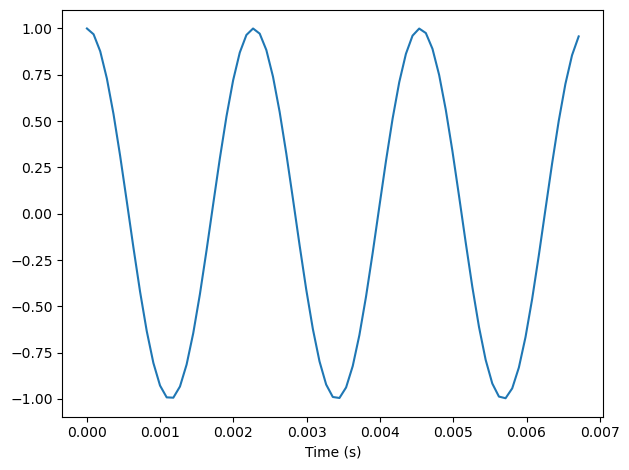

In [4]:
from thinkdsp import decorate

cos_sig.plot()
decorate(xlabel='Time (s)')

Here's the sine signal.

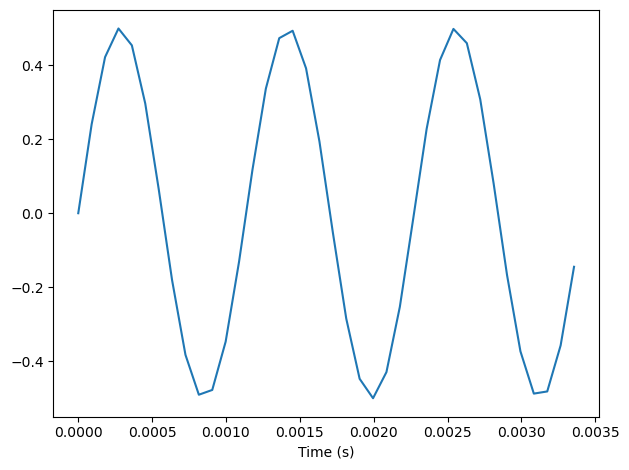

In [7]:
sin_sig.plot()
decorate(xlabel='Time (s)')

Notice that the frequency of the sine signal is doubled, so the period is halved.

The sum of two signals is a SumSignal.

In [10]:
mix = sin_sig + cos_sig
mix

Here's what it looks like.

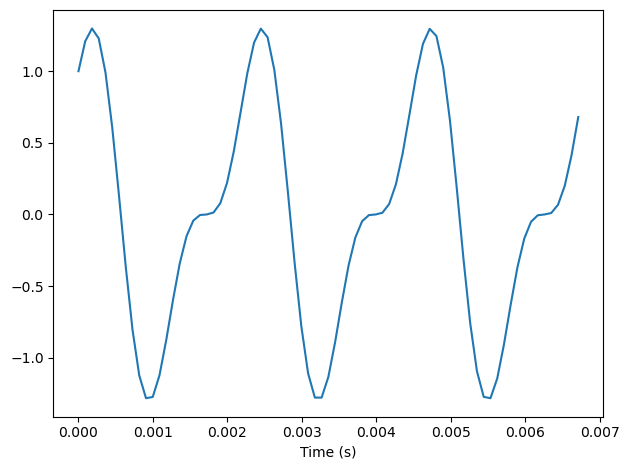

In [13]:
mix.plot()
decorate(xlabel='Time (s)')

## Waves

A Signal represents a mathematical function defined for all values of time.  If you evaluate a signal at a sequence of equally-spaced times, the result is a Wave.  `framerate` is the number of samples per second.

In [16]:
wave = mix.make_wave(duration=0.5, start=0, framerate=11025)
wave

In [26]:
wave.write('sine_wave440.wav')


Writing sine_wave440.wav


C:\Users\user\Desktop\sixth semester\telecom\telecom_aisha\code\thinkdsp.py:1161: UserWarning: Warning: normalizing before quantizing.
  warnings.warn("Warning: normalizing before quantizing.")


IPython provides an Audio widget that can play a wave.

In [31]:
from IPython.display import Audio
audio = Audio(data=wave.ys, rate=wave.framerate)
audio

Wave also provides `make_audio()`, which does the same thing:

In [34]:
wave.make_audio()

The `ys` attribute is a NumPy array that contains the values from the signal.  The interval between samples is the inverse of the framerate.

In [37]:
print('Number of samples', len(wave.ys))
print('Timestep in ms', 1 / wave.framerate * 1000)

Number of samples 5512
Timestep in ms 0.09070294784580499


Signal objects that represent periodic signals have a `period` attribute.

Wave provides `segment`, which creates a new wave.  So we can pull out a 3 period segment of this wave.

In [40]:
period = mix.period
segment = wave.segment(start=0, duration=period*3)
period

0.0022727272727272726

Wave provides `plot`

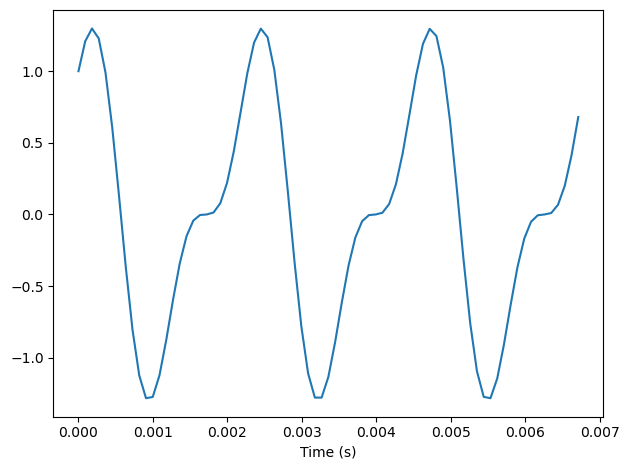

In [43]:
segment.plot()
decorate(xlabel='Time (s)')

`normalize` scales a wave so the range doesn't exceed -1 to 1.

`apodize` tapers the beginning and end of the wave so it doesn't click when you play it.

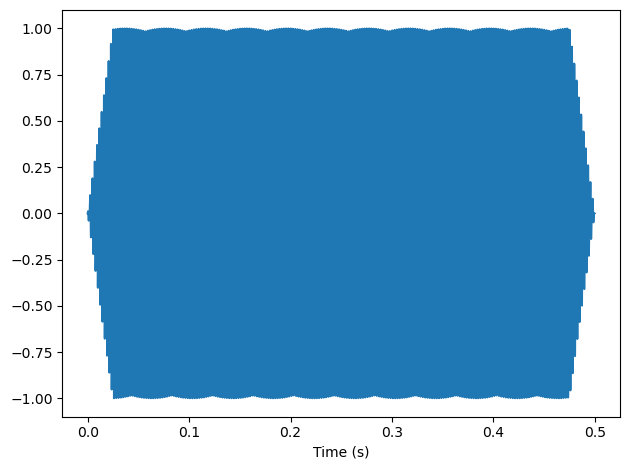

In [46]:
wave.normalize()
wave.apodize()
wave.plot()
decorate(xlabel='Time (s)')

You can write a wave to a WAV file.

In [49]:
wave.write('temp.wav')

Writing temp.wav


`wave.write` writes the wave to a file so it can be used by an exernal player.

In [52]:
from thinkdsp import play_wave

play_wave(filename='temp.wav', player='aplay')

`read_wave` reads WAV files.  The WAV examples in the book are from freesound.org.  In the contributors section of the book, I list and thank the people who uploaded the sounds I use.

In [109]:
from thinkdsp import read_wave

wave = read_wave('flute_ex1_2.wav')
wave.make_audio()


In [111]:
from thinkdsp import read_wave

wave = read_wave(filename)

In [115]:
wave.make_audio()

I pulled out a segment of this recording where the pitch is constant.  When we plot the segment, we can't see the waveform clearly, but we can see the "envelope", which tracks the change in amplitude during the segment.

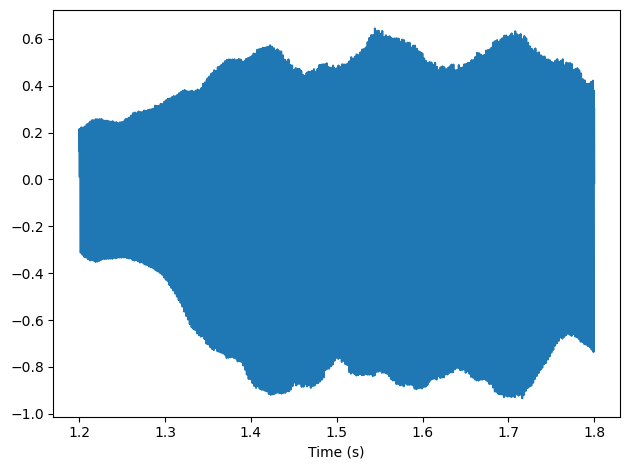

In [120]:
start = 1.2
duration = 0.6
segment = wave.segment(start, duration)
segment.plot()
decorate(xlabel='Time (s)')

## Spectrums

Wave provides `make_spectrum`, which computes the spectrum of the wave.

In [123]:
spectrum = segment.make_spectrum()

Spectrum provides `plot`

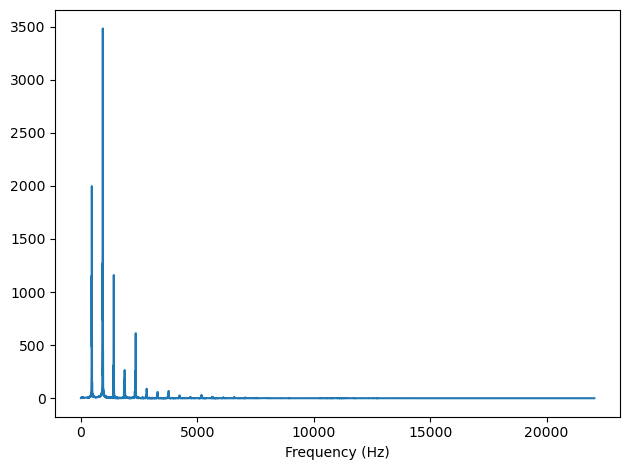

In [126]:
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

A very strong peak near 450–470 Hz → this is the fundamental frequency of the flute note (A#4 ≈ 466 Hz).
Several smaller peaks at multiples of the fundamental:
2× fundamental → 2nd harmonic,
3× fundamental → 3rd harmonic, etc.
After 5000 Hz, everything becomes very low (noise or very weak overtones).
This is typical for a real musical note — fundamental plus harmonics.

The frequency components above 5 kHz are small.  We can see the lower frequencies more clearly by providing an upper bound:

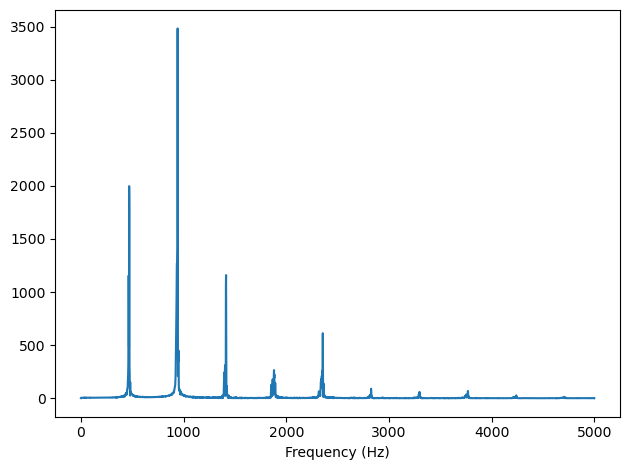

In [145]:
spectrum.plot(high=5000)
decorate(xlabel='Frequency (Hz)')

Spectrum provides `low_pass`, which applies a low pass filter; that is, it attenuates all frequency components above a cutoff frequency.

In [148]:
spectrum.low_pass(3000)

The result is a spectrum with fewer components.

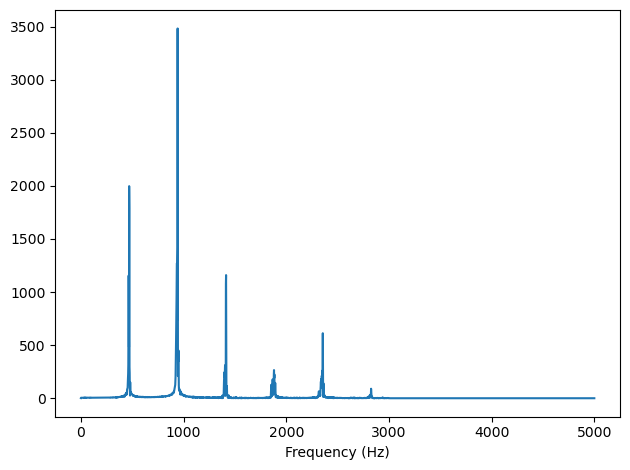

In [153]:
spectrum.plot(high=5000)
decorate(xlabel='Frequency (Hz)')

We can convert the filtered spectrum back to a wave:

In [156]:
filtered = spectrum.make_wave()

And then normalize it to the range -1 to 1.

In [159]:
filtered.normalize()

Before playing it back, I'll apodize it (to avoid clicks).

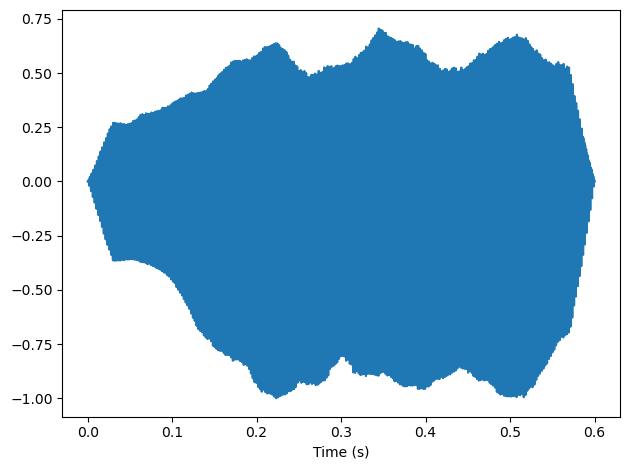

In [162]:
filtered.apodize()
filtered.plot()
decorate(xlabel='Time (s)')

And I'll do the same with the original segment.

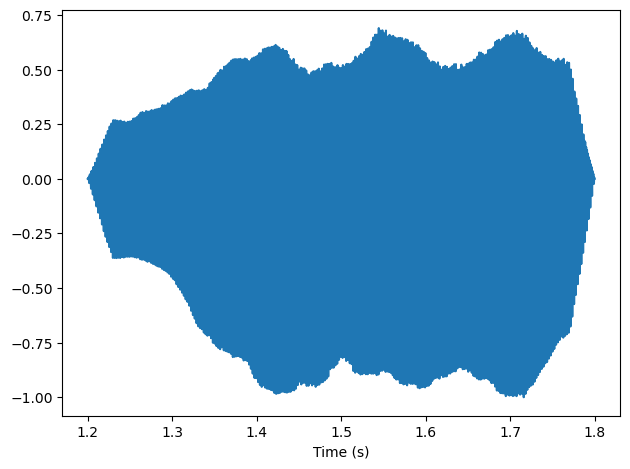

In [165]:
segment.normalize()
segment.apodize()
segment.plot()
decorate(xlabel='Time (s)')

Finally, we can listen to the original segment and the filtered version.

In [170]:
segment.make_audio()

In [172]:
filtered.make_audio()

I loaded a real flute note and selected a 0.6-second segment with a stable pitch. I computed its spectrum, revealing a strong peak around 466 Hz (the fundamental) and several harmonics.
I applied a low-pass filter to remove frequencies above a set threshold (e.g., 1000 or 3000 Hz), then normalized and apodized the result. Comparing the original and filtered versions, I observed that the original had more brightness and harmonic richness, while the filtered version sounded purer or more muffled depending on the cutoff.
This exercise helped me understand the relationship between harmonics and timbre, and how removing frequency components affects how we perceive a sound.

## Interaction

The following example shows how to use interactive IPython widgets.

In [176]:
import matplotlib.pyplot as plt
from IPython.display import display

def filter_wave(wave, start, duration, cutoff):
    """Selects a segment from the wave and filters it.
    
    Plots the spectrum and displays an Audio widget.
    
    wave: Wave object
    start: time in s
    duration: time in s
    cutoff: frequency in Hz
    """
    segment = wave.segment(start, duration)
    spectrum = segment.make_spectrum()

    spectrum.plot(color='0.7')
    spectrum.low_pass(cutoff)
    spectrum.plot(color='#045a8d')
    decorate(xlabel='Frequency (Hz)')
    plt.show()
    
    audio = spectrum.make_wave().make_audio()
    display(audio)

Adjust the sliders to control the start and duration of the segment and the cutoff frequency applied to the spectrum.

In [179]:
from ipywidgets import interact, fixed

wave = read_wave('92002__jcveliz__violin-origional.wav')
interact(filter_wave, wave=fixed(wave), 
         start=(0, 5, 0.1), duration=(0, 5, 0.1), cutoff=(0, 10000, 100));

interactive(children=(FloatSlider(value=2.0, description='start', max=5.0), FloatSlider(value=2.0, description…

ex 1.3

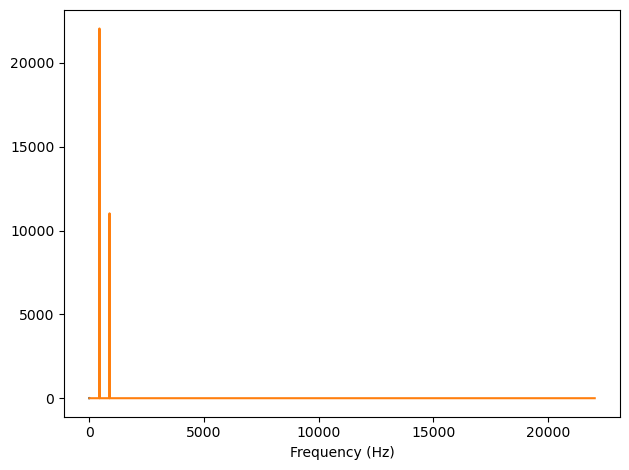

In [187]:
from thinkdsp import SinSignal, CosSignal, decorate

# Create two signals
sin1 = SinSignal(freq=440, amp=1.0)
cos1 = CosSignal(freq=880, amp=0.5)

# Add them
compound = sin1 + cos1

# Make wave
wave = compound.make_wave(duration=1.0, framerate=44100)
wave.plot()
decorate(xlabel='Time (s)')

# Listen
from IPython.display import display
display(wave.make_audio())

# Plot spectrum
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')


spectrum shows:
A strong peak around 440 Hz,
A second peak at not a multiple (e.g., 600 Hz, 730 Hz, etc.),
Both appear as clean, narrow spikes.
This confirms I am mixing two sine or cosine signals with different frequencies — and at least one is not a harmonic of the other.

What happens if you add frequency components that are not multiples of the fundamental?

Answer:
The result is a more complex and non-repeating waveform.
The sound becomes less harmonic and possibly a bit dissonant.
The waveform shape is not symmetrical or periodic like it would be with pure harmonics.
In the spectrum, you see peaks at irregular intervals, not multiples.

ex 1.4

In [189]:
def stretch(wave, factor):
    wave.ts /= factor
    wave.framerate *= factor


wave.ts /= factor : Changes the time values of the samples. If factor = 2, then each sample now takes half the time, so the waveform is longer/slower.
wave.framerate *= factor : Increases the sample rate so the system knows how fast to play the wave. If the framerate doubles, playback happens faster.

In [ ]:
TEST:

In [191]:
from thinkdsp import SinSignal
from IPython.display import display

# Create a simple sine wave
signal = SinSignal(440)
wave = signal.make_wave(duration=1.0, framerate=44100)

# Listen to the original wave
display(wave.make_audio())

# Stretch it by factor 2 (slow down)
stretch(wave, 2)

# Listen to the stretched wave
display(wave.make_audio())
